In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml

# Linear regression

In [2]:
def load_data(stock_name, price_type):
    '''
    * Stock name should be one of: 'aapl', 'ibm', 'googl', 'amzn', or 'msft'.
    * Loads the price type specified by price_type of the given stock for the past year.
    ** Options for the price type include: 'Close/Last', 'Open', 'High', 'Low'
    '''
    data = pd.read_csv('{}_data.csv'.format(stock_name))
    string_data = data[price_type].values
    numerical_data = np.array([float(s.replace('$', '')) for s in string_data])
    return numerical_data

def visualize_data(stock1_data, stock2_data, stock1_name, stock2_name):
    '''
    Visualize scatter plot where each point has (x, y) coordinates of
    (stock1 price, stock2 price) for each day
    '''
    plt.figure(figsize=(10, 6))
    plt.scatter(stock1_data, stock2_data)
    plt.xlabel('{} price'.format(stock1_name))
    plt.ylabel('{} price'.format(stock2_name))

def augment_data(stock_data):
    '''
    Append a column of ones to a given array of stock data. Input will have length corresponding
    to the number of days of data, e.g. N. Output will be of shape (N, 2)
    '''
    ones = np.ones(len(stock_data))
    return np.stack((stock_data, ones), axis=1)

def linear_regression(input_data, target_data):
    '''
    Implement linear regression where we predict the stock data in target_data
    using the input_data stock data. This function will add the column of ones to the input data for you.
    If input_data = X and target_data = y, remember our solution from linear regression:
    
    w = ((X^T)X)^(-1)(X^T)y
    '''
    augmented_input_data = augment_data(input_data)
    w = np.linalg.inv(augmented_input_data.T@augmented_input_data)@augmented_input_data.T@target_data # TODO: fill this in!
    return w

def visualize_lr_solution(input_data, target_data, w, input_name, target_name, plot_title):
    '''
    Visualize the line of best fit for your least squares solution.
    * w is your least squares solution
    '''
    input_min = np.min(input_data)
    input_max = np.max(input_data)
    x = np.linspace(input_min, input_max, 1000)
    y = w[0]*x + w[1]
    plt.figure(figsize=(10,6))
    plt.title(plot_title)
    plt.scatter(input_data, target_data, label='Data', alpha=0.7)
    plt.plot(x, y, 'r--', label='Linear Regression')
    plt.xlabel(input_name)
    plt.ylabel(target_name)
    plt.legend()

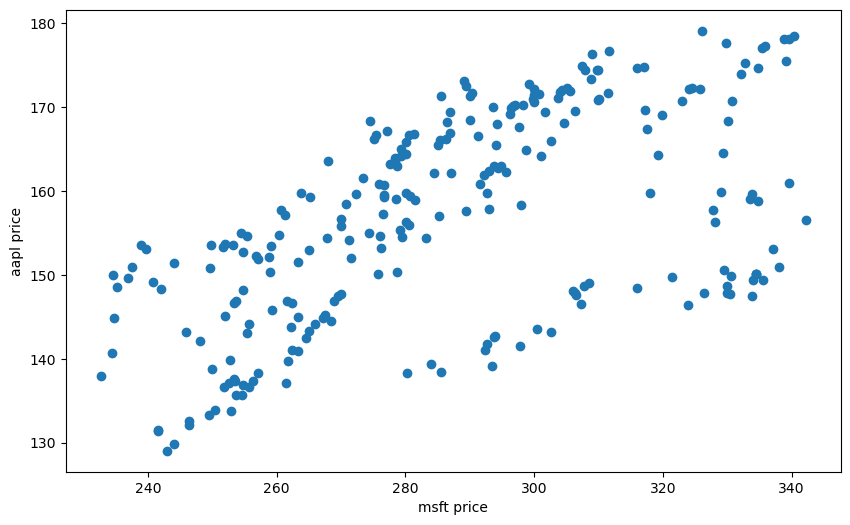

In [3]:
stock1_name = 'msft'
stock2_name = 'aapl'
price_type = 'Low'

stock1_data = load_data(stock1_name, price_type)
stock2_data = load_data(stock2_name, price_type)
visualize_data(stock1_data, stock2_data, stock1_name, stock2_name)

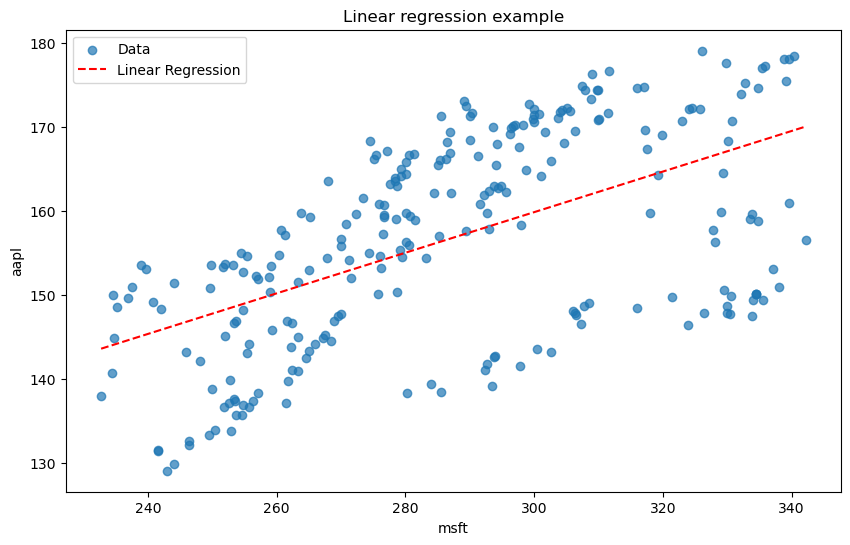

In [4]:
# Try testing out your linear regression solution here!
w = linear_regression(stock1_data, stock2_data)
visualize_lr_solution(stock1_data, stock2_data, w, stock1_name, stock2_name, 'Linear regression example')

# Logistic regression

In [7]:
# load digit data
image_vectors, digits = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
image_vectors /= 255 # change range to 0 to 1
image_vectors -= 0.5 # change range to -0.5 to 0.5
images = image_vectors.reshape(image_vectors.shape[0], 28, 28)

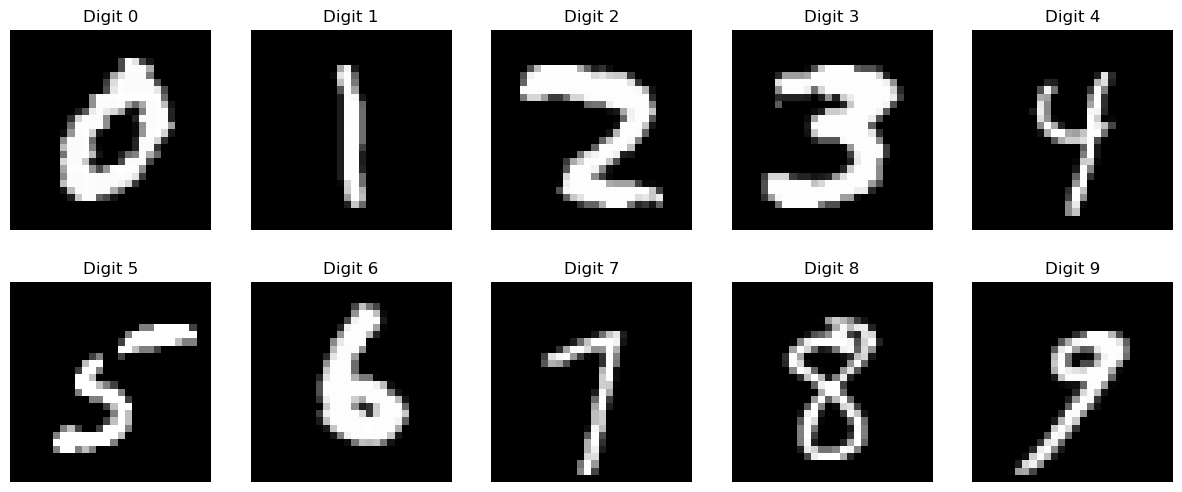

In [8]:
# pick out "N_per_digit" examples for each digit
N_per_digit = 2000
digit_indices = [np.flatnonzero(digits==str(i))[:N_per_digit] for i in range(10)]
val_digit_indices = [np.flatnonzero(digits==str(i))[N_per_digit:2*N_per_digit] for i in range(10)]
image_dict = {i: np.array([images[idx] for idx in digit_indices[i]]) for i in range(10)}
vector_dict = {i: np.array([image_vectors[idx] for idx in digit_indices[i]]) for i in range(10)}
val_vector_dict = {i: np.array([image_vectors[idx] for idx in val_digit_indices[i]]) for i in range(10)}
# plot example digits
plt.figure(figsize=(15,6))
example_idx = 3 # from 0-99
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(image_dict[i][example_idx], 'gray')
    plt.axis('off')
    plt.title('Digit {}'.format(i))

In [9]:
def logistic_regression(input_data, target_classes, step_size, n_steps):
    '''
    Compute the logistic regression parameters w using gradient descent with the given
    step_size and number of steps, n_steps.
    * input_data: (N_examples, 784) array of the digit data, N_examples = 2*N_per_digit
    * target_classes: (N_examples,) array of {-1, 1} values separating the two digit classes
    * step_size: (float) step size for gradient descent
    * n_steps: (int) number of gradient descent iterations
    '''
    w = np.zeros(input_data.shape[1]) # initialize w with all zeros
    NLL = []
    nll = negative_log_likelihood(input_data, target_classes, w)
    NLL.append(nll)
    for n in range(n_steps):
        w = gradient_descent_step(input_data, target_classes, w, step_size)
        nll = negative_log_likelihood(input_data, target_classes, w)
        NLL.append(nll)
    return w, np.array(NLL)
        
def gradient_descent_step(input_data, target_classes, w, step_size):
    '''
    Compute the gradient descent update for a given weight vector w, input data, target classes,
    and step_size
    
    Hint 1: The gradient for our cost function (negative log likelihood) in logistic regression is given by
    
    gradient for example i is: (-y_i*x_i*e^(-y_i*(w^T)x_i))
                               ----------------------------
                                   1+e^(-y_i*(w^T)x_i))
    gradient of the entire cost function is the sum of these gradients!
    
    Hint 2: w_next = w_current - step_size*gradient_of_cost_function
    '''
    N = len(target_classes)
    numerator = -target_classes*np.exp((input_data@w)*(-target_classes)) # (N,)
    denominator = 1 + np.exp((input_data@w)*(-target_classes)) # (N,)
    grad = input_data.T@(numerator/denominator)
    w_next = w - step_size*grad # TODO: write code to perform one gradient descent step
    return w_next
    

def negative_log_likelihood(input_data, target_classes, w):
    '''
    Compute the negative log likelihood of our input data and target classes
    using logistic regression weights w.
    '''
    return -np.sum(-np.log(1+np.exp(-target_classes*np.dot(input_data, w))))

def preprocess_data(digit1, digit2, vector_dict):
    '''
    Format digit images into appropriate format for "input_data" and "target_classes" variables.
    Digit1 will be assigned class label -1, digit2 will be assigned class label +1.
    '''
    input_data = np.concatenate((vector_dict[digit1], vector_dict[digit2]), axis=0)
    target_classes = np.array([-1]*len(vector_dict[digit1])+[1]*len(vector_dict[digit2]))
    return input_data, target_classes

def visualize_probabilities(input_data, target_classes, w, title):
    '''
    Visualize what the probabilities of the positive class are each example.
    '''
    probs = 1/(1+np.exp(-input_data@w))
    negative_indices = np.flatnonzero(target_classes==-1)
    positive_indices = np.flatnonzero(target_classes==1)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.scatter(probs[negative_indices], -1*np.ones(len(negative_indices)),
                color='royalblue', alpha=0.5, label='-1 class')
    plt.scatter(probs[positive_indices], np.ones(len(positive_indices)),
                color='darkorange', alpha=0.5, label='+1 class')
    plt.vlines(0.5, -1.1, 1.1, colors='red', linestyles='dashed')
    plt.xlabel('Probability of +1 class')
    plt.ylabel('Ground-truth class')
    plt.legend()
    
def accuracy(input_data, target_classes, w):
    '''
    Compute classification accuracy for given input data and target classes using
    logistic regression solution w. An example is predicted for class +1 if the probability
    is greater than 0.5.
    '''
    preds = 1 / (1+np.exp(-input_data@w)) > 0.5
    labels = target_classes==1
    accuracy = np.sum(preds==labels)/len(labels)
    return accuracy

In [10]:
digit1 = 3
digit2 = 8

input_data, target_classes = preprocess_data(digit1, digit2, vector_dict)
val_input_data, val_target_classes = preprocess_data(digit1, digit2, val_vector_dict)

Training accuracy = 0.981
Validation accuracy = 0.969


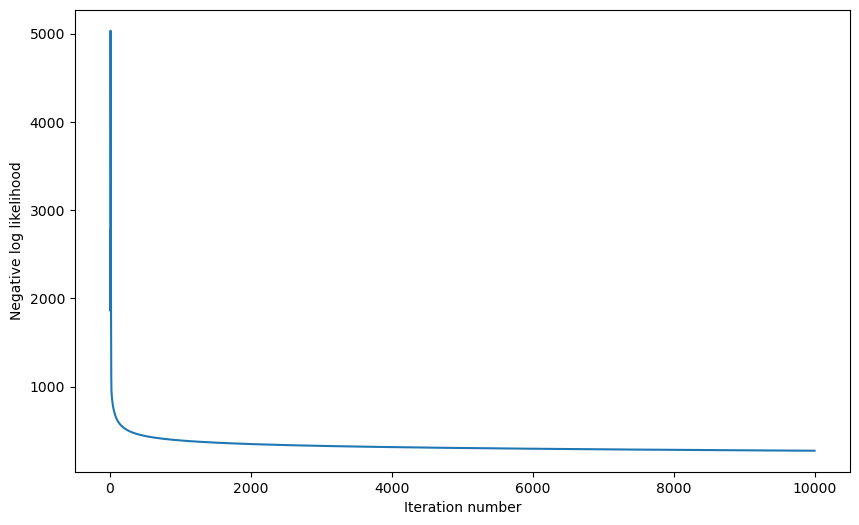

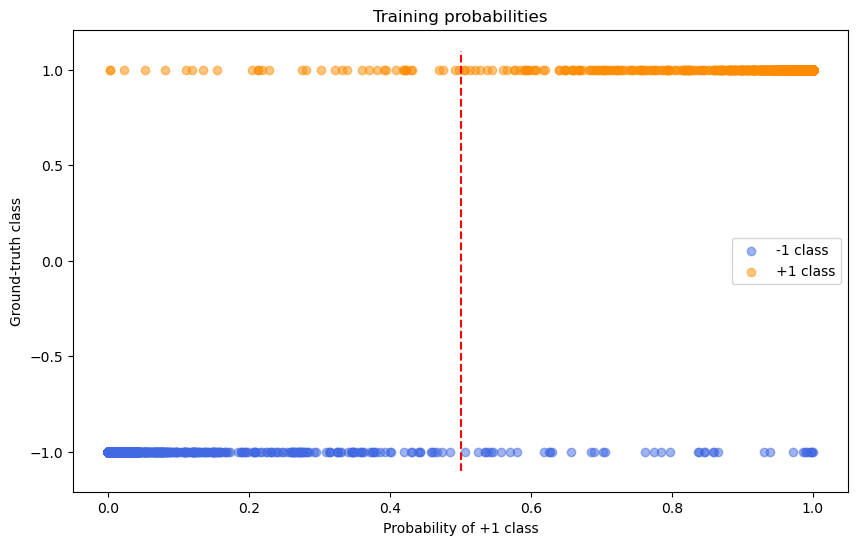

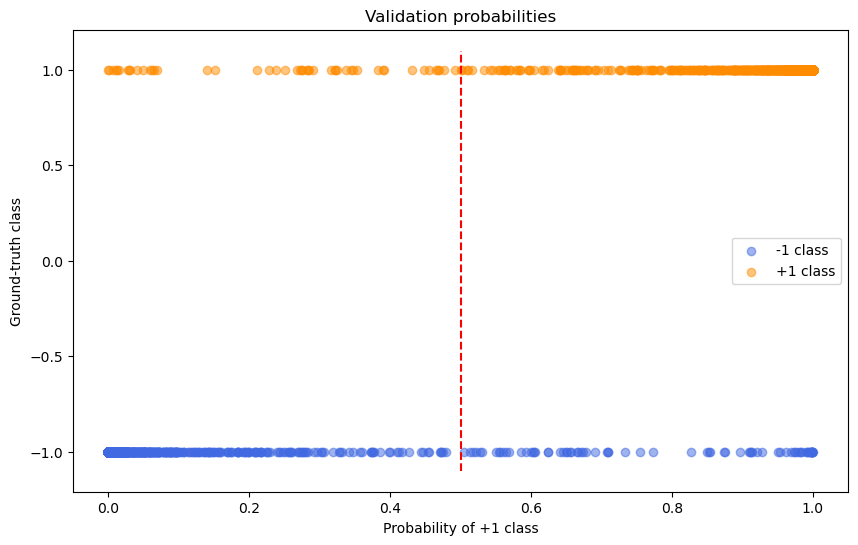

In [11]:
# Try your logistic regression code here!
step_size = 3e-5
n_steps = 10000
w, L = logistic_regression(input_data, target_classes, step_size, n_steps)
plt.figure(figsize=(10, 6))
plt.plot(L)
plt.xlabel('Iteration number')
plt.ylabel('Negative log likelihood')

visualize_probabilities(input_data, target_classes, w, 'Training probabilities')
visualize_probabilities(val_input_data, val_target_classes, w, 'Validation probabilities')
print('Training accuracy = {:.3f}'.format(accuracy(input_data, target_classes, w)))
print('Validation accuracy = {:.3f}'.format(accuracy(val_input_data, val_target_classes, w)))